In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
from seispy.station import homestake
from scipy.linalg import pinv2,svd
from numpy.linalg import inv
plt.style.use('stylesheet.mplstyle')
from scipy.io import savemat
import astropy.units as u
import numpy as np
import os
os.environ['PROJ_LIB'] = '/home/patrick.meyers/anaconda3/envs/meyers/share/proj'
import seispy.plot as hplot
import healpy as hp

In [2]:
 # parameters for injections
amplitude = 1e-4 #UNITS? m? dimensionless? other?
freq = 1 #Hz
tick_font_size=20
duration=3000
velocity=5700
fftlength = 5
directions=[[0,90]] # list of (phi,theta) pairs (direction of wave destination with current conventions)
nside = 8
# set up array
stations=homestake(origin='TPK')

In [3]:
print(stations)

StationArray([('DEAD', [3500.3748630000046, 4707.410118999891, 0]), ('LHS', [1838.5767560000531, 749.3708429997787, 0]), ('ORO', [3638.374279999989, 354.34171899966896, 0]), ('ROSS', [3213.2142300000414, 525.6443229997531, 0]), ('RRDG', [2567.3913020000327, 2115.7334890002385, 0]), ('SHL', [7072.574416000047, -2547.801388000138, 0]), ('TPK', [0.0, 0.0, 0]), ('WTP', [4417.751750000054, 1521.707585000433, 0]), ('YATES', [3687.421085000038, 1321.6673060003668, 0]), ('300', [3266.819923000061, 670.8881149999797, 91.44]), ('800', [3105.7245670000557, 779.5472999997437, 243.84]), ('1700', [3138.340991999954, 1257.7745399996638, 518.16]), ('A2000', [2828.5197049999842, 1186.4274030001834, 609.6]), ('B2000', [2975.1721990000224, 977.5526980003342, 609.6]), ('C2000', [2716.1014859999996, 1240.2807700000703, 609.6]), ('D2000', [2298.8268910000334, 1422.869591999799, 609.6]), ('E2000', [2078.4824350000126, 1763.973942999728, 609.6]), ('A4100', [3540.3565429999726, 508.39149899967015, 1249.68]), (

In [4]:
data = SeismometerArray.initialize_all_good(stations, duration, chans_type='fast_chans')
Nsims = 1
data.add_p_wave(amplitude / np.sqrt(Nsims), np.radians(0), np.radians(90),freq,duration=duration, c=velocity, phase_noise_amp=0)
data.add_white_noise(1e-7)
Ys = data.get_coherences(freq, fft_duration=fftlength) / fftlength**2

2628


100%|██████████| 24/24 [01:13<00:00,  3.05s/it]


In [5]:
G_healpy,shapes = data.get_gamma_matrix_healpy('p',stations,velocity,freq, nside=nside)
Fisher = np.dot(G_healpy.conj(), G_healpy.T)
full_inv = inv(Fisher)
u, s, vh = svd(Fisher, full_matrices=False, check_finite=False) # get svd

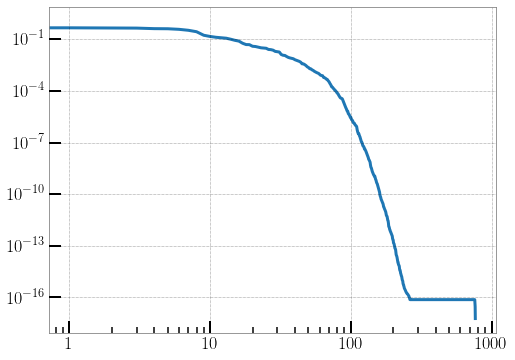

In [6]:
plt.plot(s/np.max(s))
plt.xscale('log')
plt.yscale("log")
plt.show()

In [7]:
def solve(G_healpy, coherences, cond=1e-6, u=None, vh=None, s=None):
    Fisher = np.dot(G_healpy.conj(), G_healpy.T)
    if u is None or vh is None or s is None:
        u, s, vh = svd(Fisher, full_matrices=False, check_finite=False)
    rank = np.sum(s > cond * np.max(s))
    psigma_diag = 1.0 / s[: rank]
    InvFisher = np.transpose(np.conjugate(np.dot(u[:, : rank] *
                                             psigma_diag, vh[: rank])))
    dirty_map = np.dot(G_healpy.conj(), coherences)
    MRM = InvFisher.dot(Fisher)
    return np.real(np.dot(InvFisher, dirty_map)), MRM

In [8]:
def plot_map(ax, mymap, mymin, mymax):
    hplot.healpix_heatmap(mymap, cmap='RdBu_r', vmin=mymin, vmax=mymax)
    ax.grid(True)
    # plt.title(r'$p$-wave recovery for $r$ and $p$-wave injection',y=1.08, fontsize=30)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(tick_font_size)
    h = plt.colorbar(orientation='horizontal', pad=0.05, fraction=0.08)
    h.ax.tick_params(labelsize=tick_font_size)
    text = h.ax.xaxis.get_offset_text()
    h.ax.set_xlabel('Recovered power [$\\rm{m^2}$]')
    text.set_size(26)

1.02590621832e-08


/home/patrick.meyers/anaconda3/envs/seismic_work/lib/python3.9/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))
/home/patrick.meyers/git_repos/seismic_radiometer/seispy/plot.py:496: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdBu_r").copy()
  aximg.cmap.set_bad('w', alpha=0.)
/home/patrick.meyers/anaconda3/envs/seismic_work/lib/python3.9/site-packages/numpy/ma/core.py:3381: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


1.02576956588e-08
1.0253411674e-08
1.02178645787e-08


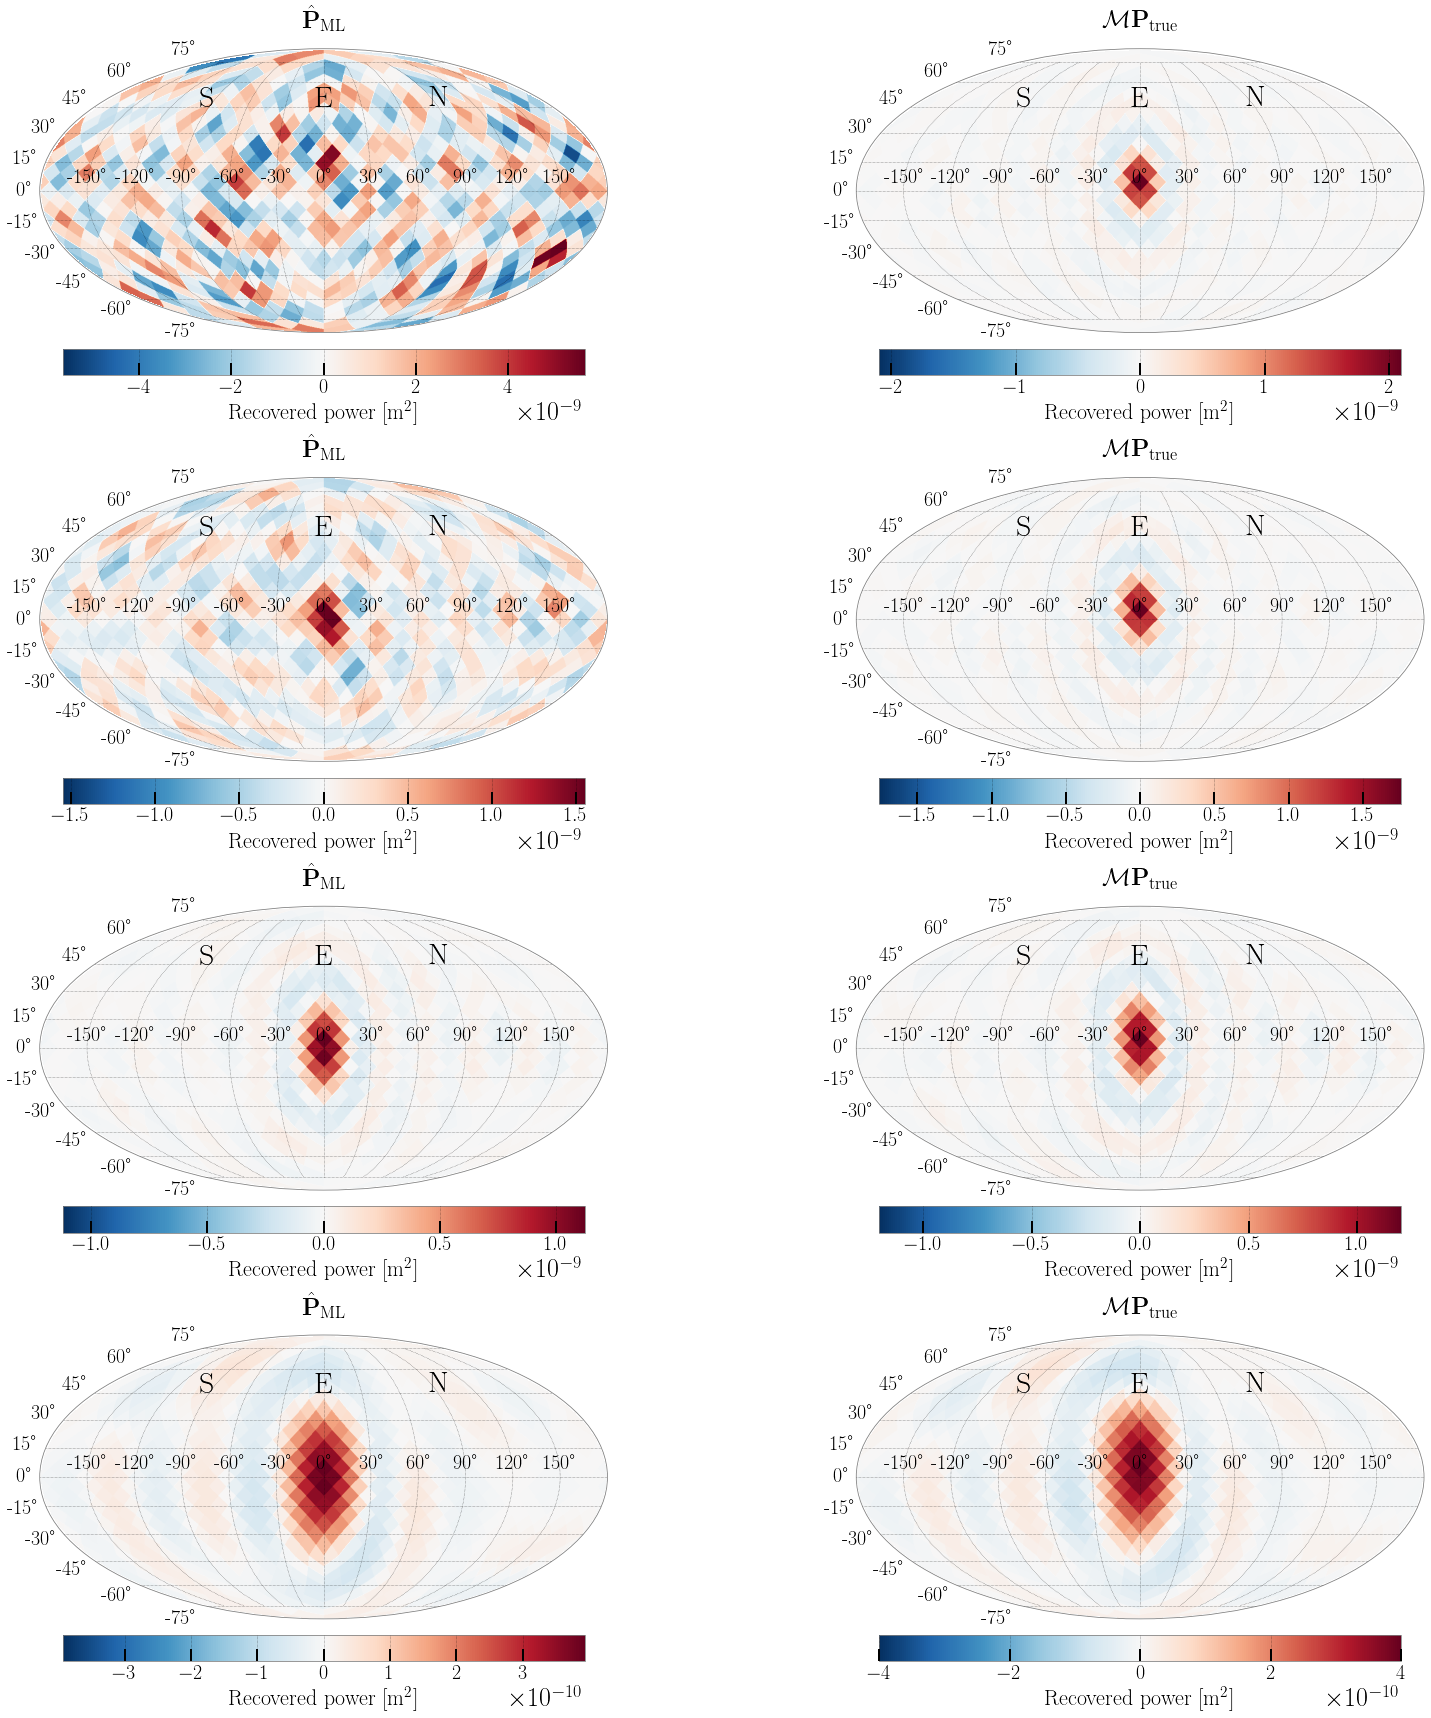

In [9]:
plt.figure(figsize=(12*2,6*4))
ax = plt.gca()
mymap, MRM = solve(G_healpy, Ys, cond=1e-10, u=u, vh=vh, s=s)
print(np.sum(mymap))
MRM *= amplitude**2
ax = plt.subplot(421, projection='mollweide')
ax.set_title('$\\hat{ \\rm{{\\bf P}}}_{\\rm ML}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
plot_map(ax, mymap, -np.abs(mymap).max(), np.abs(mymap).max())
ax = plt.subplot(422, projection='mollweide')
ax.set_title('$\\mathcal{M} \\rm{{\\bf P}}_{\\rm true}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
idx = hp.pixelfunc.ang2pix(nside, np.pi/2, 0)
plot_map(ax, MRM[:, idx], -np.abs(MRM[:, idx]).max(), np.abs(MRM[:, idx]).max())

mymap, MRM = solve(G_healpy, Ys, cond=1e-8, u=u, vh=vh, s=s)
print(np.sum(mymap))
MRM *= amplitude**2
ax = plt.subplot(423, projection='mollweide')
ax.set_title('$\\hat{ \\rm{{\\bf P}}}_{\\rm ML}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
plot_map(ax, mymap, -np.abs(mymap).max(), np.abs(mymap).max())
ax = plt.subplot(424, projection='mollweide')
ax.set_title('$\\mathcal{M}  \\rm{{\\bf P}}_{\\rm true}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
idx = hp.pixelfunc.ang2pix(nside, np.pi/2, 0)
plot_map(ax, MRM[:, idx], -np.abs(MRM[:, idx]).max(), np.abs(MRM[:, idx]).max())


mymap, MRM = solve(G_healpy, Ys, cond=1e-5, u=u, vh=vh, s=s)
print(np.sum(mymap))
MRM *= amplitude**2
ax = plt.subplot(425, projection='mollweide')
ax.set_title('$\\hat{ \\rm{{\\bf P}}}_{\\rm ML}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
plot_map(ax, mymap, -np.abs(mymap).max(), np.abs(mymap).max())
ax = plt.subplot(426, projection='mollweide')
ax.set_title('$\\mathcal{M}  \\rm{{\\bf P}}_{\\rm true}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
idx = hp.pixelfunc.ang2pix(nside, np.pi/2, 0)
plot_map(ax, MRM[:, idx], -np.abs(MRM[:, idx]).max(), np.abs(MRM[:, idx]).max())


mymap, MRM = solve(G_healpy, Ys, cond=1e-2, u=u, vh=vh, s=s)
print(np.sum(mymap))
MRM *= amplitude**2
ax = plt.subplot(427, projection='mollweide')
ax.set_title('$\\hat{ \\rm{{\\bf P}}}_{\\rm ML}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
plot_map(ax, mymap, -np.abs(mymap).max(), np.abs(mymap).max())
ax = plt.subplot(428, projection='mollweide')
ax.set_title('$\\mathcal{M}  \\rm{{\\bf P}}_{\\rm true}$', y=1.05)
ax.tick_params(labelsize=tick_font_size)
ax.text(np.radians(-7),np.radians(45),'E', fontsize=30)
ax.text(np.radians(90-7),np.radians(45),'N', fontsize=30)
# ax.text(np.radians(180-5),np.radians(60),'W', fontsize=20)
ax.text(np.radians(-90-7),np.radians(45),'S', fontsize=30)
idx = hp.pixelfunc.ang2pix(nside, np.pi/2, 0)
plot_map(ax, MRM[:, idx], -np.abs(MRM[:, idx]).max(), np.abs(MRM[:, idx]).max())
plt.tight_layout()
plt.savefig('smin_study.pdf')
plt.savefig('smin_study.png')